In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
import gym
from gym import wrappers

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class REINFORCE:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = 0.001
        self.gamma = 0.99
        self.pi = nn.Sequential(
            nn.Linear(self.num_states, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_actions),
            nn.Softmax()
        )
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.alpha)
        self.memory = []
        
    def calculate_returns(self, rewards):
        returns = torch.zeros(rewards.shape)
        g_t = 0
        for t in reversed(range(0,len(rewards))):
            g_t = g_t * .99 + rewards[t].item()
            returns[t] = g_t
        return returns.detach()
        
    def append_sample(self, state, action, reward):
        state = torch.FloatTensor(state)
        reward = torch.FloatTensor([reward])
        self.memory.append((state, action, reward))
        
    def update(self):
        states = torch.stack([m[0] for m in self.memory])
        actions = torch.stack([m[1] for m in self.memory]) 
        rewards = torch.stack([m[2] for m in self.memory])
        
        returns = self.calculate_returns(rewards)
        returns = (returns - returns.mean()) / returns.std()
        self.optimizer.zero_grad()
        policy_log_probs = self.pi(torch.FloatTensor(states)).log()
        policy_loss = torch.cat([-lp[a].unsqueeze(0) * g for a, lp, g in zip(actions, policy_log_probs, returns)])
        policy_loss = policy_loss.sum()
        policy_loss.backward()
        
        self.optimizer.step()
            
        self.memory = []
        return policy_loss.item()
    
    def act(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state)
            policy_probs = torch.distributions.Categorical(self.pi(state))

        return policy_probs.sample()
        

In [3]:
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, "./video", force=True)
observation = env.reset()
agent = REINFORCE(observation.shape[0], 2)

observation

array([ 0.01359152, -0.03975019, -0.0469824 , -0.03837624])

In [4]:
rewards = []
for ep in range(500):
    done = False
    obs = env.reset()
    action = agent.act(obs)

    ep_rewards = 0
    while not done:
        next_obs, reward, done, info = env.step(action.item())
        ep_rewards += reward
        next_action = agent.act(next_obs)

        agent.append_sample(obs, action, reward)
        obs = next_obs
        action = next_action
    pi_loss = agent.update()
    rewards.append(ep_rewards)
    if (ep+1) % 10 == 0:
        print("episode: {}, loss: {:.3f}, rewards: {:.3f}".format(ep+1, pi_loss, ep_rewards))
env.close()

episode: 10, loss: -0.236, rewards: 49.000
episode: 20, loss: 0.608, rewards: 26.000
episode: 30, loss: 0.233, rewards: 22.000
episode: 40, loss: -0.135, rewards: 23.000
episode: 50, loss: -0.114, rewards: 24.000
episode: 60, loss: -0.310, rewards: 28.000
episode: 70, loss: -0.157, rewards: 12.000
episode: 80, loss: -0.061, rewards: 20.000
episode: 90, loss: 0.310, rewards: 37.000
episode: 100, loss: 0.268, rewards: 26.000
episode: 110, loss: -0.457, rewards: 67.000
episode: 120, loss: -2.139, rewards: 19.000
episode: 130, loss: 0.061, rewards: 11.000
episode: 140, loss: -0.027, rewards: 28.000
episode: 150, loss: -1.572, rewards: 17.000
episode: 160, loss: -1.448, rewards: 44.000
episode: 170, loss: -0.265, rewards: 54.000
episode: 180, loss: -0.659, rewards: 41.000
episode: 190, loss: -0.518, rewards: 83.000
episode: 200, loss: 1.388, rewards: 20.000
episode: 210, loss: 1.045, rewards: 41.000
episode: 220, loss: -1.892, rewards: 75.000
episode: 230, loss: -2.115, rewards: 39.000
epis

In [5]:
from utils import show_video

show_video()

In [6]:
pd.Series(rewards).to_csv('./logs/rewards_reinforce_cartpole.csv')

In [8]:
deepsarsa_logs = pd.read_csv('./logs/rewards_deepsarsa.csv', index_col=False).iloc[:, 1]
reinforce_logs = pd.read_csv('./logs/rewards_reinforce_cartpole.csv', index_col=False).iloc[:, 1]


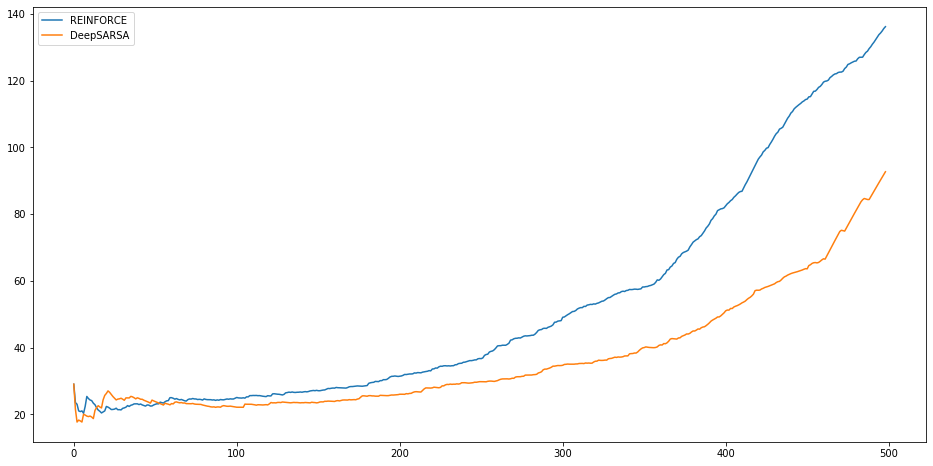

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(reinforce_logs.cumsum() / (pd.Series(np.arange(reinforce_logs.shape[0]))+1), label="REINFORCE")
plt.plot(deepsarsa_logs.cumsum() / (pd.Series(np.arange(deepsarsa_logs.shape[0]))+1), label="DeepSARSA")
plt.legend()